In [ ]:
if (!require("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

BiocManager::install("DESeq2")
install.packages("readxl")

# Load necessary libraries
library(DESeq2)
library(ggplot2)
library(tidyverse)
library(readxl)
library(dplyr)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.rstudio.com

Bioconductor version 3.21 (BiocManager 1.30.26), R 4.5.1 (2025-06-13)

Installing package(s) 'BiocVersion', 'DESeq2'

also installing the dependencies ‘formatR’, ‘UCSC.utils’, ‘GenomeInfoDbData’, ‘abind’, ‘SparseArray’, ‘lambda.r’, ‘futile.options’, ‘GenomeInfoDb’, ‘XVector’, ‘S4Arrays’, ‘DelayedArray’, ‘futile.logger’, ‘snow’, ‘BH’, ‘S4Vectors’, ‘IRanges’, ‘GenomicRanges’, ‘SummarizedExperiment’, ‘BiocGenerics’, ‘Biobase’, ‘BiocParallel’, ‘matrixStats’, ‘locfit’, ‘MatrixGenerics’, ‘RcppArmadillo’


Old packages: 'gargle', 'ragg', 'textshaping'

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Loading required package: S4Vectors

Loading required package: stats4

Loading required p

In [ ]:
packageVersion("DESeq2")

[1] ‘1.48.2’

In [ ]:
counts_data <- read.csv("/content/counts_file.csv")
counts_data <- na.omit(counts_data)
counts_data <- counts_data %>%
  column_to_rownames(var = "Geneid")
if (any(counts_data < 0)) { counts_data[counts_data < 0] <- 0 }
print(tail(counts_data))

condition <- read.table("/content/condition_file.txt", header = TRUE, fill = TRUE, row.names = 1)
batch <- read.csv("/content/batch_file.csv", header = TRUE, fill = TRUE, row.names = 1)

conditions <- as.vector(condition[, 1])
# Check if conditions and counts_data have matching column names
if (ncol(counts_data) != length(conditions)) {
  stop("Error: Number of conditions does not match the number of columns in counts_data")
}
colData <- data.frame(row.names = colnames(counts_data), condition = conditions, batch = batch)  # <-- Added batch to colData
colData$condition <- as.factor(colData$condition)

# Ensure "control" is a valid reference level
#if ("Control" %in% levels(colData$condition)) {
#  colData$condition <- relevel(colData$condition, ref = "Control")
#} else {
#  stop("Error: 'somthing wrong in condition' is not an existing level in the condition column.")
#}

condition_batch <- as.vector(batch[, 1]) # convert to vector
colData$batch <- condition_batch

print(colData)
print(nrow(counts_data))

                SRR21043221 SRR21043229 SRR21043237 SRR21043277 SRR21043303
ENSG00000169045        2284        2926        2817        2942        3091
ENSG00000163138           4           4           3           2           1
ENSG00000135486        1779        2217        1922        2151        2331
ENSG00000168488         612         711         609         692         793
ENSG00000111640         872        1223        1382        1407        1335
ENSG00000108465         290         324         303         328         375
                SRR21043311 SRR21043319 SRR21043386 SRR21043394 SRR21043378
ENSG00000169045        2773        2474        3355        2801        3044
ENSG00000163138           0           1           4           0           1
ENSG00000135486        2236        1980        2701        2224        1146
ENSG00000168488         752         688         778         788         940
ENSG00000111640        1310         990        1795        1163        1167
ENSG00000108

In [ ]:
dds <- DESeqDataSetFromMatrix(countData = counts_data, colData = colData, design = ~ condition)
filter2 <- rowSums(counts(dds) >= 10) > (ncol(dds) / 2) # strict filter
dds <- dds[filter2,]
print(dds)

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]



class: DESeqDataSet 
dim: 9478 68 
metadata(1): version
assays(1): counts
rownames(9478): ENSG00000127837 ENSG00000090861 ... ENSG00000111640
  ENSG00000108465
rowData names(0):
colnames(68): SRR21043221 SRR21043229 ... SRR21043814 SRR21043816
colData names(2): condition batch


Spearmen condition that were followed in the paper:

In [ ]:
# VST makes variance  approximately constant across the range of mean values.
# Explanation: Reduces the differences in variability (spread) of gene expression levels between genes that are lowly expressed and those that are highly expressed.
vsd <- vst(dds, blind = FALSE)
vsd_mat <- assay(vsd)

# Calculate the Spearman correlation matrix, and keep the samples that meet the cutoff range
cor_matrix <- cor(vsd_mat, method = "spearman")
one_minus_spearman <- 1 - cor_matrix
#print(one_minus_spearman)
cutoff <- 0.1
samples_to_keep <- apply(one_minus_spearman, 2, function(x) any(x < cutoff & x > 0))
samples_names_to_keep <- colnames(one_minus_spearman)[samples_to_keep]
print(samples_names_to_keep)

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]



 [1] "SRR21043221" "SRR21043229" "SRR21043237" "SRR21043277" "SRR21043303"
 [6] "SRR21043311" "SRR21043319" "SRR21043386" "SRR21043394" "SRR21043378"
[11] "SRR21043434" "SRR21043442" "SRR21043460" "SRR21043468" "SRR21043476"
[16] "SRR21043516" "SRR21043524" "SRR21043559" "SRR21043599" "SRR21043633"
[21] "SRR21043673" "SRR21043689" "SRR21043681" "SRR21043716" "SRR21043732"
[26] "SRR21043740" "SRR21043748" "SRR21043788" "SRR21043780" "SRR21043818"
[31] "SRR21043834" "SRR21043826" "SRR21043874" "SRR21043882" "SRR21043866"
[36] "SRR21043889" "SRR21043905" "SRR21043897" "SRR21043945" "SRR21043937"
[41] "SRR21043194" "SRR21043195" "SRR21043193" "SRR21043196" "SRR21043332"
[46] "SRR21043333" "SRR21043334" "SRR21043331" "SRR21043431" "SRR21043432"
[51] "SRR21043433" "SRR21043430" "SRR21043556" "SRR21043557" "SRR21043555"
[56] "SRR21043558" "SRR21043614" "SRR21043611" "SRR21043612" "SRR21043613"
[61] "SRR21043670" "SRR21043669" "SRR21043671" "SRR21043672" "SRR21043815"
[66] "SRR21043817" "SRR21

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



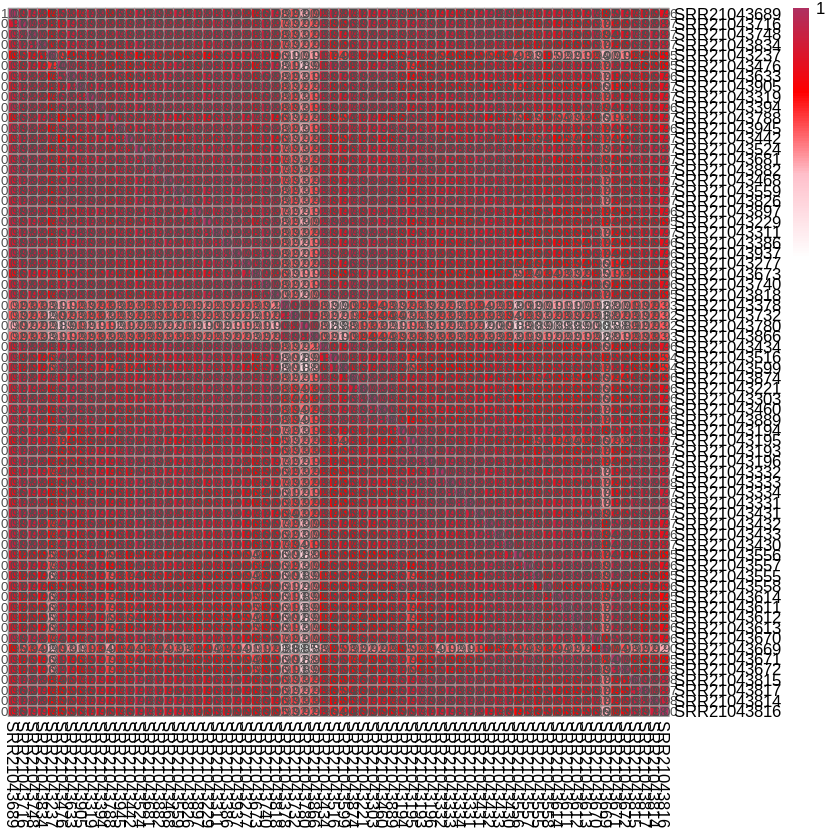

In [ ]:
install.packages("pheatmap")
library(pheatmap)
install.packages("RColorBrewer")
library(RColorBrewer)

sample_order <- order(colData$condition)
cor_matrix_copy <- cor_matrix[sample_order, sample_order]
ordered_conditions <- colData$condition[sample_order]

# Replace the row and column names in the correlation matrix with condition names
#rownames(cor_matrix_copy) <- ordered_conditions
#colnames(cor_matrix_copy) <- ordered_conditions
pheatmap(cor_matrix_copy,
         clustering_distance_rows = "correlation",
         clustering_distance_cols = "correlation",
         cluster_rows = FALSE,  # Disable clustering
         cluster_cols = FALSE,  # Disable clustering
         color = colorRampPalette(c("white","pink","red","maroon"))(100),
         legend = TRUE,  # Add legend for color
         legend_breaks = seq(-1, 1, 0.2),  # Define breaks for correlation values
         legend_labels = round(seq(-1, 1, 0.2), 2),  # Label the legend
         display_numbers = TRUE,  # Show correlation values on the heatmap
         fontsize_number = 8)  # Adjust font size for the correlation values

In [ ]:
dds <- DESeq(dds)
res <- results(dds)
summary(res)

significant_genes <- res[which(!is.na(res$padj) & res$padj < 0.05), ]
significant_genes_sorted <- significant_genes[order(significant_genes$padj), ]
print("Helloo!")
print(significant_genes_sorted)

# Create a dataframe to create file for gsea
write_res <- results(dds)
df <- data.frame(gene = rownames(write_res), stat = res$log2FoldChange)
df_sorted <- df[order(-df$stat), ]
x = readline()
write.csv(df_sorted, paste0("log2foldsorted_file_", x, ".csv"), row.names = FALSE)

estimating size factors

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

final dispersion estimates

fitting model and testing

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  fo


out of 9478 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 176, 1.9%
LFC < 0 (down)     : 245, 2.6%
outliers [1]       : 0, 0%
low counts [2]     : 184, 1.9%
(mean count < 11)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results

[1] "Helloo!"
log2 fold change (MLE): condition DMSO vs BPA .0.0005. 
Wald test p-value: condition DMSO vs BPA .0.0005. 
DataFrame with 272 rows and 6 columns
                 baseMean log2FoldChange     lfcSE      stat      pvalue
                <numeric>      <numeric> <numeric> <numeric>   <numeric>
ENSG00000196208 1021.8217      -1.451342 0.1321526 -10.98231 4.64857e-28
ENSG00000111907 1231.6038      -0.546775 0.0621894  -8.79210 1.46788e-18
ENSG00000160182 4486.1695      -1.022793 0.1217873  -8.39819 4.53406e-17
ENSG00000163644  265.8608      -0.562531 0.0708673  -7.93781 2.05787e-15
ENSG00000165731   56.4198      -1.110038 0.1416136  -7.83850 4.55977e-15
...                   ...     

In [ ]:
num_upregulated <- sum(significant_genes$log2FoldChange > 0)
num_downregulated <- sum(significant_genes$log2FoldChange < 0)

cat("Number of upregulated genes:", num_upregulated, "\n")
cat("Number of downregulated genes:", num_downregulated, "\n")

Number of upregulated genes: 97 
Number of downregulated genes: 175 


Creating the PCA plots

using ntop=500 top features by variance



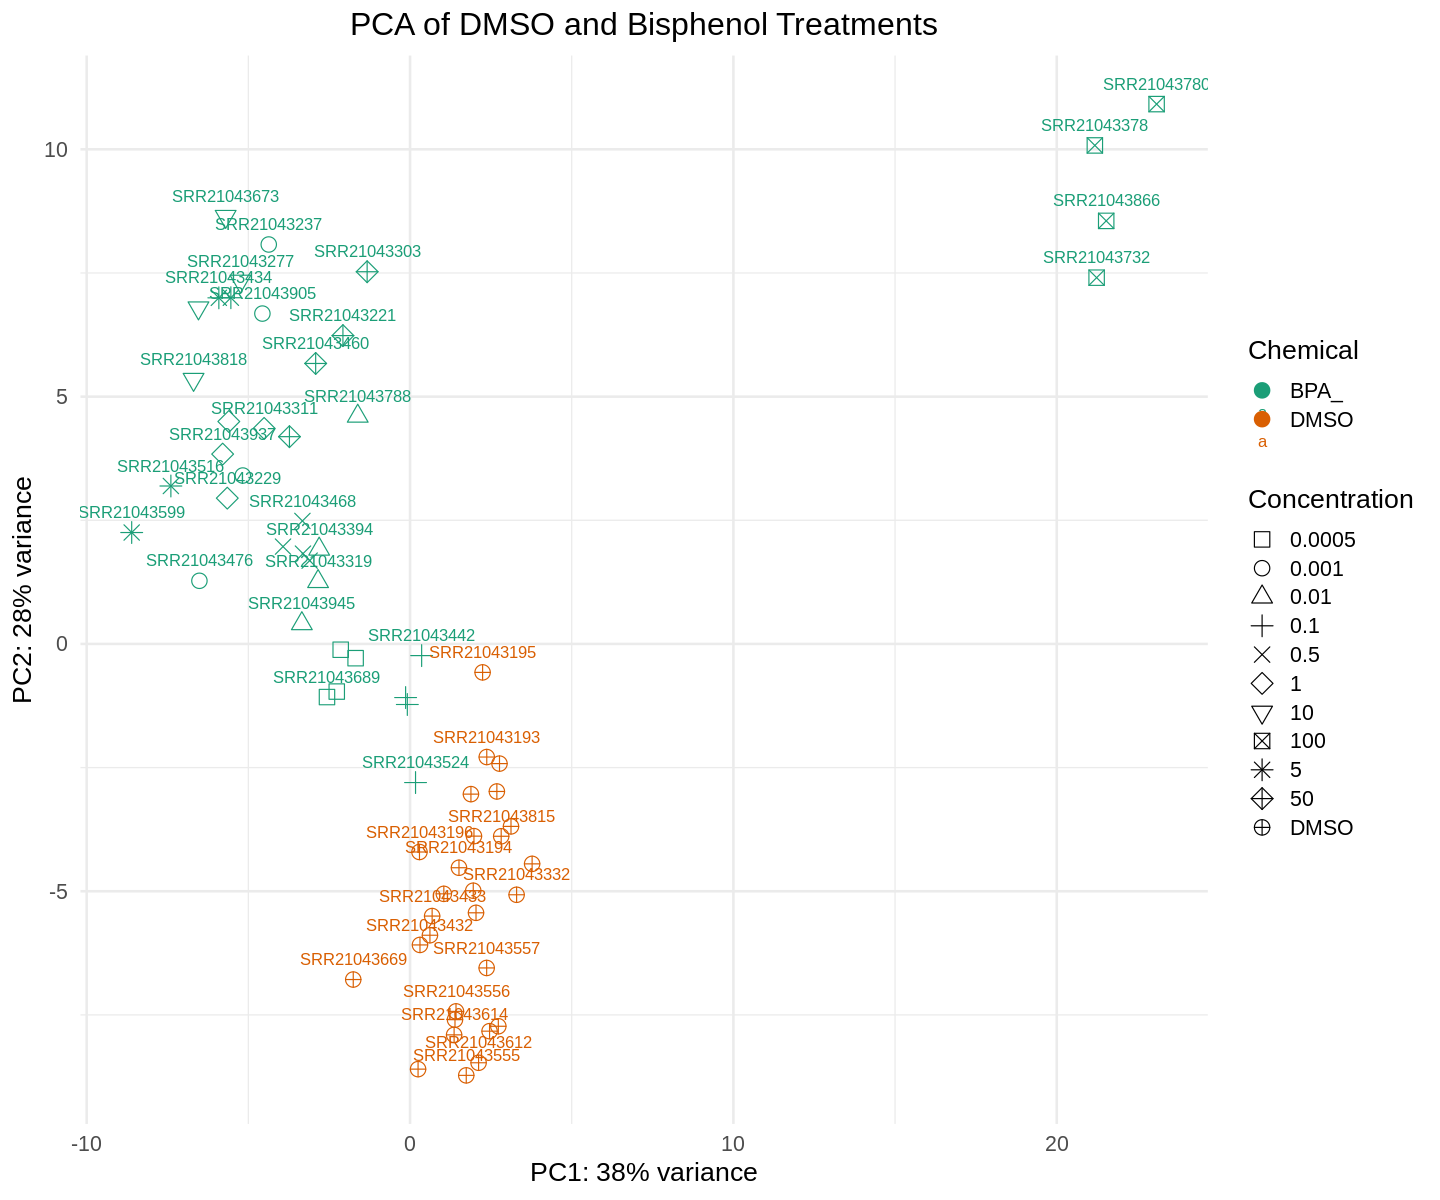

In [ ]:
library(ggplot2)

# Extract PCA data
pcaData <- plotPCA(vsd, intgroup = "condition", returnData = TRUE)
percentVar <- round(100 * attr(pcaData, "percentVar"))

# Extract chemical and concentration from condition like "BPA[0.01]"
pcaData$Chemical <- gsub("\\[.*", "", pcaData$condition)  # everything before [
pcaData$Concentration <- gsub(".*\\[|\\]", "", pcaData$condition)  # value inside [ ]

# Create a custom label for shape or tooltip
pcaData$ChemDose <- ifelse(
  pcaData$Chemical == "DMSO",
  "Control",
  paste0(pcaData$Chemical, " ", pcaData$Concentration, " µM")
)

# Set color by Chemical (distinct colors), shape by Concentration
pcaData$Concentration <- factor(pcaData$Concentration)
pcaData$Chemical <- factor(pcaData$Chemical)
pcaData$SampleID <- colnames(vsd)

# Plot
p <- ggplot(pcaData, aes(x = PC1, y = PC2, color = Chemical, shape = Concentration, label = SampleID)) +
  geom_point(size = 4) +
  geom_text(vjust = -1.2, size = 3.5, check_overlap = TRUE) +
  xlab(paste0("PC1: ", percentVar[1], "% variance")) +
  ylab(paste0("PC2: ", percentVar[2], "% variance")) +
  theme_minimal(base_size = 16) +
  ggtitle("PCA of DMSO and Bisphenol Treatments") +
  theme(plot.title = element_text(hjust = 0.5)) +
  scale_color_brewer(palette = "Dark2") +
  scale_shape_manual(values = 0:25)

# Optional: adjust plot dimensions if in notebook
options(repr.plot.width = 12, repr.plot.height = 10)
print(p)


PCA 2 VS PCA 3

Warning message in scales::rescale(as.numeric(as.character(pcaData$Concentration)), :
“NAs introduced by coercion”


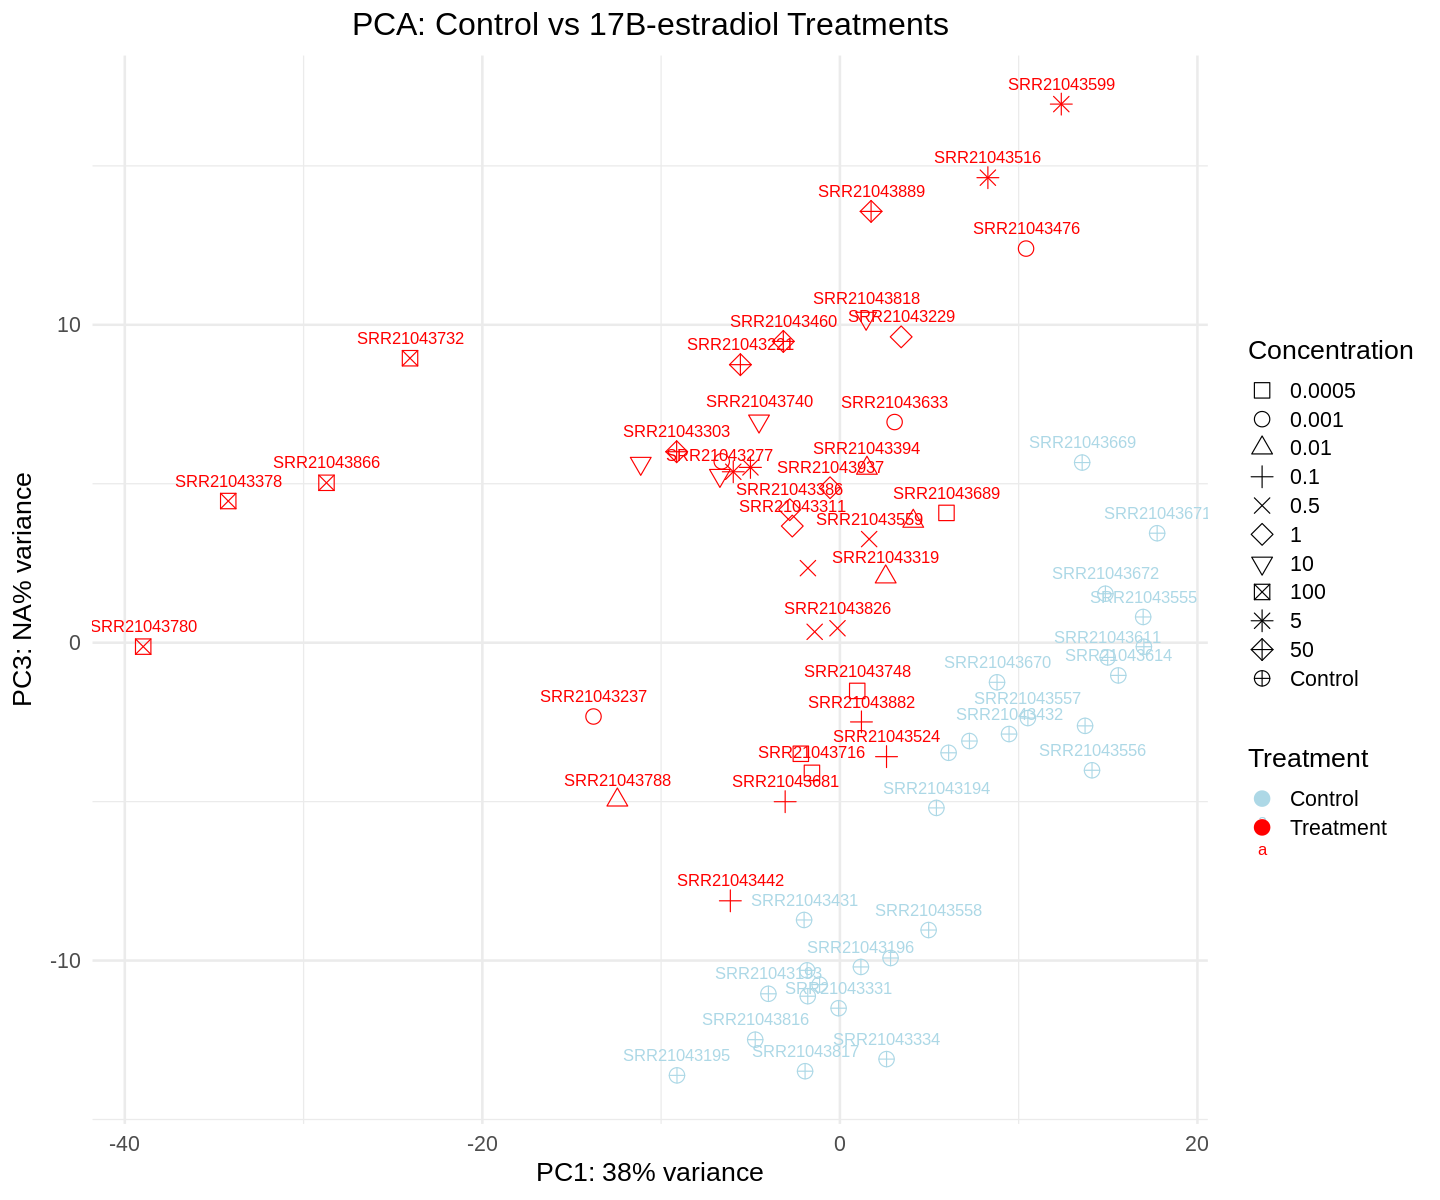

In [ ]:
# Get the matrix of variance-stabilized values
vsd_mat <- assay(vsd)

# Transpose so that samples are rows, genes are columns
pca <- prcomp(t(vsd_mat))
# Create data frame with first few PCs
pcaData <- as.data.frame(pca$x[, 1:5])  # adjust if you want more PCs

# Add condition info from colData
pcaData$condition <- colData(vsd)$condition

# Label Control vs Treatment
pcaData$Treatment <- ifelse(pcaData$condition == "DMSO", "Control", "Treatment")

# Extract concentration
pcaData$Concentration <- ifelse(
  pcaData$Treatment == "Control",
  "Control",
  gsub(".*\\[|\\]", "", pcaData$condition)
)
pcaData$Concentration <- as.factor(pcaData$Concentration)
pcaData$SampleID <- colnames(vsd)
# Optional: Add point size if you'd like to scale by concentration
pcaData$PointSize <- ifelse(
  pcaData$Treatment == "Control",
  2,
  scales::rescale(as.numeric(as.character(pcaData$Concentration)), to = c(2, 6))
)
p <- ggplot(pcaData, aes(x = PC1, y = PC3, color = Treatment, shape = Concentration, label = SampleID)) +
  geom_point(size = 4) +
  geom_text(vjust = -1.2, size = 3.5, check_overlap = TRUE) +  # Add sample labels above points
  xlab(paste0("PC1: ", percentVar[1], "% variance")) +
  ylab(paste0("PC3: ", percentVar[3], "% variance")) +
  scale_color_manual(values = c("Control" = "#ADD8E6", "Treatment" = "red")) +  # Light blue for Control
  scale_shape_manual(values = 0:25) +
  theme_minimal(base_size = 16) +
  ggtitle("PCA: Control vs 17B-estradiol Treatments") +
  theme(plot.title = element_text(hjust = 0.5))


options(repr.plot.width = 12, repr.plot.height = 10)  # adjust as needed
print(p)

In [ ]:
pdf(paste0("DESeq2_report_", x, ".pdf"))
# MA plot (log fold change vs mean expression)
plotMA(res, main = "MA Plot", ylim = c(-5, 5))

# PCA plot to visualize sample clustering
vsd <- vst(dds, blind = FALSE)
plotPCA(vsd, intgroup = "condition")

# Dispersion plot to visualize gene variability
plotDispEsts(dds)

# Cook's distance for outlier detection (for one sample)
plot(seq_along(assays(dds)[["cooks"]][,1]), assays(dds)[["cooks"]][,1], type = "h",
     main = "Cook's Distance for Sample 1", xlab = "Genes", ylab = "Cook's Distance")

# Heatmap of sample distances
sampleDists <- dist(t(vsd_mat))
sampleDistMatrix <- as.matrix(sampleDists)
heatmap(sampleDistMatrix, symm = TRUE, main = "Sample Distance Heatmap")
# the heatmap made above is better so use that

# Close the PDF device
dev.off()

using ntop=500 top features by variance



pdf 
  2

Creating GCT file

In [ ]:
BiocManager::install("fgsea")
BiocManager::install("msigdbr")
if (!requireNamespace("AnnotationDbi", quietly = TRUE)) {
  BiocManager::install("AnnotationDbi")
}
if (!requireNamespace("org.Hs.eg.db", quietly = TRUE)) {
  BiocManager::install("org.Hs.eg.db")
}
BiocManager::install("msigdbr")
library(AnnotationDbi)
library(org.Hs.eg.db)
library(msigdbr)
library(fgsea)
library(stringr)
library(ggplot2)

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.rstudio.com

Bioconductor version 3.21 (BiocManager 1.30.25), R 4.5.0 (2025-04-11)

Warning message:
“package(s) not installed when version(s) same as or greater than current; use
  `force = TRUE` to re-install: 'fgsea'”
Old packages: 'httpuv', 'miniUI'

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.rstudio.com

Bioconductor version 3.21 (BiocManager 1.30.25), R 4.5.0 (2025-04-11)

Warning message:
“package(s) not installed when version(s) same as or greater than current; use
  `force = TRUE` to re-install: 'msigdbr'”
Old packages: 'httpuv', 'miniUI'

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for detail

In [ ]:
# Extract normalized counts from DESeq2
normalized_counts <- counts(dds, normalized=TRUE)

# Remove any rows with missing or empty row names
valid_rows <- !is.na(rownames(normalized_counts)) & rownames(normalized_counts) != ""
filtered_counts <- normalized_counts[valid_rows, ]

# Convert Ensembl IDs to gene symbols
gene_symbols <- mapIds(
  org.Hs.eg.db,
  keys = rownames(filtered_counts),  # Use Ensembl IDs as keys
  column = "SYMBOL",
  keytype = "ENSEMBL",
  multiVals = "first"
)

# Filter out rows with NA gene symbols (failed mappings)
filtered_counts <- filtered_counts[!is.na(gene_symbols), ]
rownames(filtered_counts) <- gene_symbols[!is.na(gene_symbols)]

# Retrieve sample metadata
sample_metadata <- colData(dds)

# Ensure the metadata contains a 'condition' column
if (!"condition" %in% colnames(sample_metadata)) {
  stop("Metadata does not contain a 'condition' column. Check your sample metadata.")
}

# Convert condition values to lowercase for consistency
sample_metadata$condition <- tolower(sample_metadata$condition)

# Ensure only expected conditions ("treatment" and "control") exist
valid_conditions <- c("Treatment", "Control")

# Map alternative formats to standard conditions
sample_metadata$condition <- ifelse(sample_metadata$condition %in% c("treatment", "treated"), "treatment",
                                    ifelse(sample_metadata$condition %in% c("control", "untreated"), "control", NA))

# Check for unexpected condition values
if (any(is.na(sample_metadata$condition))) {
  stop("Unexpected condition values found in sample metadata. Ensure all samples are labeled as 'treatment' or 'control'.")
}

# Define factor levels to enforce ordering (treatment first, control second)
sample_metadata$condition <- factor(sample_metadata$condition, levels = valid_conditions)

# Ensure sample names and conditions are correctly paired before sorting
sample_names_before <- rownames(sample_metadata)
conditions_before <- sample_metadata$condition

# Get sample names sorted according to the desired condition order
sorted_sample_names <- rownames(sample_metadata)[order(sample_metadata$condition)]

# Ensure sorted order is correctly applied
sample_names_after <- sorted_sample_names
conditions_after <- sample_metadata$condition[order(sample_metadata$condition)]

# Print sample order before and after reordering (for debugging)
message("Sample order before sorting: ", paste(sample_names_before, conditions_before, sep=":", collapse=", "))
message("Sample order after sorting: ", paste(sample_names_after, conditions_after, sep=":", collapse=", "))

# Reorder columns in filtered_counts based on sorted order
filtered_counts <- filtered_counts[, sorted_sample_names]

# Final check: Ensure column names match expected sorted names
if (!all(colnames(filtered_counts) == sorted_sample_names)) {
  stop("Error: Column names in filtered_counts do not match sorted sample names. Possible mismatch detected.")
}

# Function to write GCT file
write_gct <- function(data_matrix, output_file) {
  # Get the number of genes (rows) and samples (columns)
  num_genes <- nrow(data_matrix)
  num_samples <- ncol(data_matrix)

  # Open file connection
  fileConn <- file(output_file, "w")

  # Write the first two lines (headers)
  writeLines("#1.2", fileConn)  # GCT version
  writeLines(paste(num_genes, num_samples, sep="\t"), fileConn)  # Dimensions of the matrix

  # Prepare the data: add "Name" and "Description" columns
  gene_ids <- rownames(data_matrix)
  description <- ifelse(is.na(gene_ids) | gene_ids == "", "Unknown", "NA")  # Handle missing descriptions
  gct_data <- cbind(Name=gene_ids, Description=description, data_matrix)

  # Write the table (gene ids, descriptions, and counts)
  write.table(gct_data, file=fileConn, sep="\t", row.names=FALSE, col.names=TRUE, quote=FALSE)

  # Close the file connection
  close(fileConn)
}

# Call the function to write the GCT file
output_file <- paste0("deseq_normalized_counts_for_", x, ".gct")
write_gct(filtered_counts, output_file)

# Confirm success
message("GCT file successfully written: ", output_file)

'select()' returned 1:many mapping between keys and columns

Sample order before sorting: SRR21043276:NA, SRR21043515:NA, SRR21043598:NA, SRR21043936:NA, SRR21043816:NA, SRR21043814:NA, SRR21043817:NA, SRR21043815:NA

Sample order after sorting: SRR21043276:NA, SRR21043515:NA, SRR21043598:NA, SRR21043936:NA, SRR21043816:NA, SRR21043814:NA, SRR21043817:NA, SRR21043815:NA

GCT file successfully written: deseq_normalized_counts_for_Dex0.1.gct



In [ ]:
# Load required libraries
library(AnnotationDbi)
library(org.Hs.eg.db)
library(dplyr)

# Extract DESeq2 results
write_res <- results(dds)

# Convert Ensembl IDs to gene symbols safely
gene_symbols <- mapIds(
  org.Hs.eg.db,
  keys = rownames(write_res),  # Ensembl IDs
  column = "SYMBOL",           # Convert to Gene Symbols
  keytype = "ENSEMBL",         # Input type is Ensembl IDs
  multiVals = "first"          # Take the first matching gene symbol
)

# Convert to character vector to avoid issues with NA replacement
gene_symbols <- as.character(gene_symbols)

# Handle cases where mapping fails: replace missing gene symbols with their Ensembl IDs
gene_symbols[is.na(gene_symbols)] <- rownames(write_res)[is.na(gene_symbols)]

# Create a dataframe, ensuring all columns have the same length
df <- data.frame(
  gene = gene_symbols,           # Gene symbols
  ensembl_id = rownames(write_res),  # Keep original Ensembl IDs for reference
  stat = write_res$padj,         # Adjusted p-values
  log2FoldChange = write_res$log2FoldChange,  # Log2 fold change
  pvalue = write_res$pvalue,     # Raw p-values
  baseMean = write_res$baseMean,  # Mean of normalized counts
  stringsAsFactors = FALSE       # Prevent automatic factor conversion
)

# Remove rows with completely missing values (if any)
df <- df %>% filter(!is.na(stat) & !is.na(log2FoldChange) & !is.na(pvalue) & !is.na(baseMean))

# Sort the dataframe by padj (stat) in ascending order
df_sorted <- df[order(df$stat, na.last = TRUE), ]

# Save the sorted dataframe as a CSV file
write.csv(df_sorted, "fileFORbiostatsquidALLSTAT.csv", row.names = FALSE)

# Print a message to confirm
cat("File successfully saved: fileFORbiostatsquidALLSTAT.csv\n")

'select()' returned 1:many mapping between keys and columns



File successfully saved: fileFORbiostatsquidALLSTAT.csv


In [ ]:
gene_symbols[is.na(gene_symbols)] <- rownames(write_res)[is.na(gene_symbols)]

# Create a dataframe, ensuring all columns have the same length
df <- data.frame(
  gene = gene_symbols,           # Gene symbols
  ensembl_id = rownames(write_res),  # Keep original Ensembl IDs for reference
  stat = write_res$padj,         # Adjusted p-values
  log2FoldChange = write_res$log2FoldChange,  # Log2 fold change
  stringsAsFactors = FALSE       # Prevent automatic factor conversion
)

# Remove rows with completely missing values (if any)
df <- df %>% filter(!is.na(stat) & !is.na(log2FoldChange))

# Sort the dataframe by padj (stat) in ascending order
df_sorted <- df[order(df$stat, na.last = TRUE), ]
significant_genes <- df_sorted[which(!is.na(df_sorted$stat) & df_sorted$stat < 0.05), ]

# Save the sorted dataframe as a CSV file
write.csv(significant_genes, paste0("sigGenes_", x, ".csv"), row.names = FALSE)